## 1.import libraries and Data

In [1]:
# import the libraries that we will use
import os
import pandas as pd
import numpy as  np
import pylab as plt
import seaborn as sns
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

# import the tdt library
import tdt

In [2]:
# get help on the function tdt.read_block()
tdt.read_block?

In [3]:
block_path = 'C:/TDT/Synapse/Tanks/JJ-YG-Experimental Data/JJ-YG-Experimental Data/mouse-240328-164206'
block_path

'C:/TDT/Synapse/Tanks/JJ-YG-Experimental Data/JJ-YG-Experimental Data/mouse-240328-164206'

In [4]:
FPdata = tdt.read_block(block_path)
FPdata

Found Synapse note file: C:/TDT/Synapse/Tanks/JJ-YG-Experimental Data/JJ-YG-Experimental Data/mouse-240328-164206\Notes.txt
read from t=0s to t=1264.43s


epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])

## 2.browse data 

위의 한 줄 코드로 block 내의 모든 데이터 반입. 반입된 data는 structured object(dictionary type in Python)임.</br>
데이터 크기가 커서 그 중 일부만 반입하는 것도 가능. 자세한 내용은 도움말 참고. </br>
tdt.read_block(PATH_BLOCK).info 명령어로 data에 대한 자세한 정보 확인 가능. 

In [ ]:
FPdata.info

Streams 데이터에 접근

In [5]:
# export isosbestic and GCaMP signals
control_raw = FPdata.streams['_405A'].data
signal_raw = FPdata.streams['_465A'].data
control_raw, signal_raw

(array([ 0.20236003,  0.19946924,  0.19788872, ..., 63.279835  ,
        63.2719    , 63.263596  ], dtype=float32),
 array([ 0.29407924,  0.27770096,  0.2625761 , ..., 58.24108   ,
        58.215454  , 58.189564  ], dtype=float32))

In [6]:
#control sample 수 확인
num_sample = len(control_raw)
num_sample

1286144

In [7]:
#control sampling rate 확인
sampling_rate = FPdata.streams['_405A'].fs
sampling_rate

1017.2526245117188

In [8]:
# time in second array 생성
time_seconds = np.linspace(1, num_sample, num_sample)/sampling_rate
time_seconds

array([9.83039980e-04, 1.96607996e-03, 2.94911994e-03, ...,
       1.26432901e+03, 1.26432999e+03, 1.26433097e+03])

In [9]:
time_seconds_1 = time_seconds[np.min(np.where(time_seconds >= 1.0)):]
control_raw_1 = control_raw[np.min(np.where(time_seconds >= 1.0)):]
signal_raw_1 = signal_raw[np.min(np.where(time_seconds >= 1.0)):]

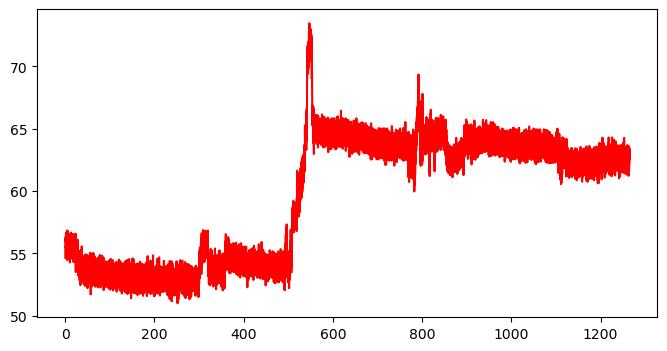

In [22]:
fig_405A = plt.subplots(figsize=(8,4))
plt.plot(time_seconds_1, control_raw_1, 'r')
plt.show()

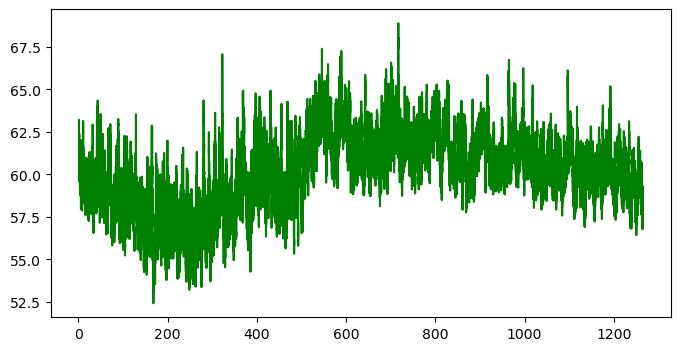

In [23]:
fig_465A = plt.subplots(figsize=(8,4))
plt.plot(time_seconds_1, signal_raw_1, 'g')
plt.show()

## 3.Raw signals

Let's take a look at the raw GCaMP and isosbestic control signals.

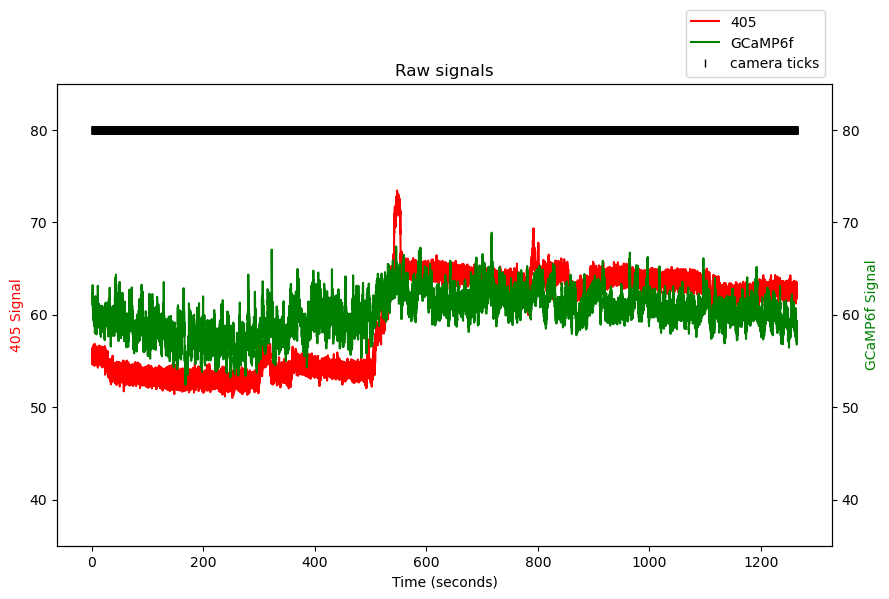

In [12]:
# plot signals
fig,ax1=plt.subplots(figsize=(10,6))  # create a plot to allow for dual y-axes plotting
plot1=ax1.plot(time_seconds_1, control_raw_1, 'r', label='405') #plot 405 on left y-axis
ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
plot2=ax2.plot(time_seconds_1, signal_raw_1, 'g', label='GCaMP6f') # plot GCaMP on right y-axis

# Plot image acquisition times as ticks.
camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 80), label='camera ticks', color='w', marker="|", mec='k')


ax1.set_ylim(35, 85)
# ax1.set_xlim(5, 10) # 초단위로 입력하여 x-axis zoom in 가능 
ax2.set_ylim(35, 85)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('405 Signal', color='r')
ax2.set_ylabel('GCaMP6f Signal', color='g')
ax1.set_title('Raw signals')

lines = plot1 + plot2 +camera_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1)) #add legend

In [29]:
FPdata.epocs.Cam1

name:	'Cam1'
onset:	array([7.08280320e-01, 7.55957760e-01, 8.07567360e-01, ...,
       9.25265265e+02, 9.25322445e+02, 9.25369631e+02])
offset:	array([7.55957760e-01, 8.07567360e-01, 8.54589440e-01, ...,
       9.25322445e+02, 9.25369631e+02,            inf])
type:	'onset'
type_str:	'epocs'
data:	array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 1.8423e+04, 1.8424e+04,
       1.8425e+04])
dform:	4
size:	10

In [30]:
data = {'onset':FPdata.epocs.Cam1.onset, 'offset': FPdata.epocs.Cam1.offset}
df_Cam_ticks = pd.DataFrame(data=data)
df_Cam_ticks

,onset,offset
0,0.708280,0.755958
1,0.755958,0.807567
2,0.807567,0.854589
3,0.854589,0.904561
4,0.904561,0.954532
...,...,...
18413,925.170237,925.213983
18414,925.213983,925.265265
18415,925.265265,925.322445
18416,925.322445,925.369631


In [31]:
# df_Cam_ticks.to_csv('79M_WT_Cam1.csv', header=False)

## Denoising (+baseline 보정)
rolling mean이나 low-pass filtering 방법이 일반적으로 사용되며, low-pass filtering에서는 Butterworth filter 또는 Savitzky-Golay filter가 사용됨. 

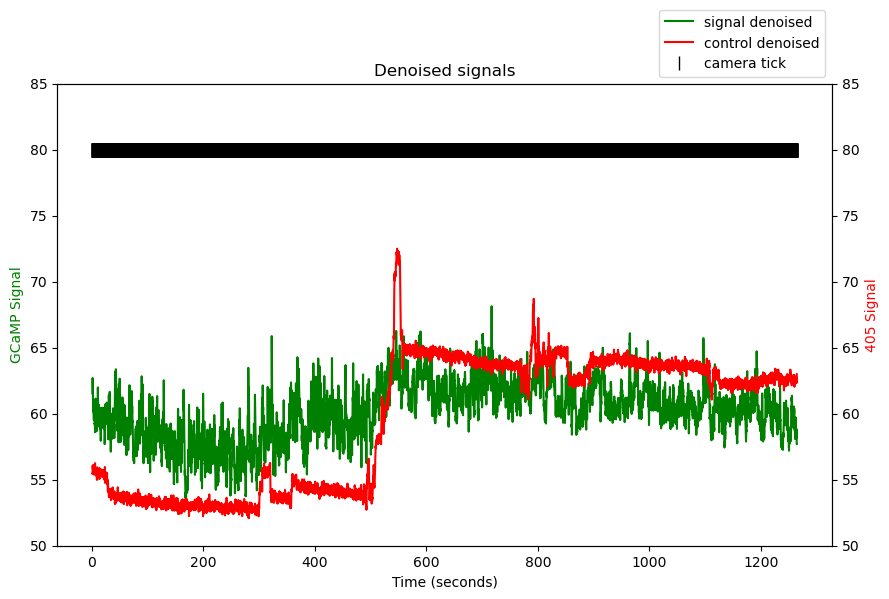

In [17]:
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 2, btype='low', fs=sampling_rate)
signal_denoised = filtfilt(b,a, signal_raw_1)
control_denoised = filtfilt(b,a, control_raw_1)

fig,ax1=plt.subplots(figsize=(10,6))
plot1=ax1.plot(time_seconds_1, signal_denoised, 'g', label='signal denoised')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_denoised, 'r', label='control denoised')
camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 80), label='camera tick', color='w', marker="|", mec='k', ms=10)

ax1.set_ylim(50, 85)
ax2.set_ylim(50, 85)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal', color='g')
ax2.set_ylabel('405 Signal', color='r')
ax1.set_title('Denoised signals')

lines = plot1+plot2 +camera_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1)) #add legend

Let's zoom in on the x-axis to see how the lowpass filtering has smoothed the signals.

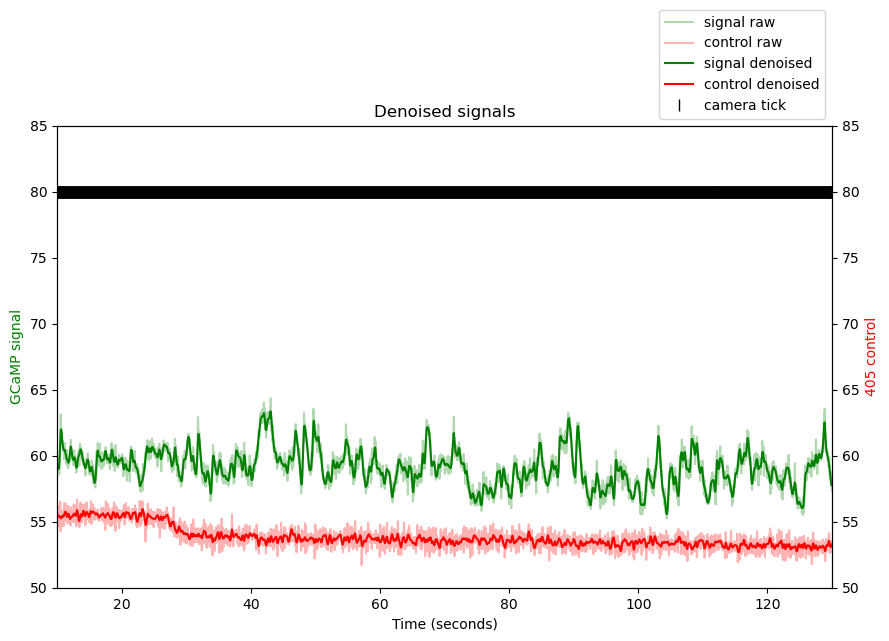

In [31]:
fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_seconds_1, signal_raw_1, color='g', alpha=0.3, label='signal raw')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_raw_1, color='r', alpha=0.3, label='control raw') 
plot3=ax1.plot(time_seconds_1, signal_denoised, color='g', label='signal denoised') 
plot4=ax2.plot(time_seconds_1, control_denoised, color='r', label='control denoised') 
camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 80), label='camera tick',color='w', marker="|", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP signal', color='g')
ax2.set_ylabel('405 control', color='r')
ax1.set_title('Denoised signals')

lines = plot1+plot2 + plot3 + plot4 + camera_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1))
ax1.set_xlim(10, 130) # 60 sec window
ax1.set_ylim(50, 85)
ax2.set_ylim(50, 85);

### Photobleaching correction
Now let's compare some different ways of removing the influence of photobleaching

#### Method 1: Double Exponential Fit
One way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal (note, some groups divide the signal by the baseline rather than subtracting the baseline, see Fiber Photometry Primer for more discussion). In practice we find that a double exponential fit is preferable to a single exponential fit because there are typically multiple sources of fluorescence that contribute to the bleaching (e.g. autofluorescence from fiber, autofluorescence from brain tissue, and flurophore fluorescence), which may bleach at different rates, so a single exponential fit can be overly restrictive.

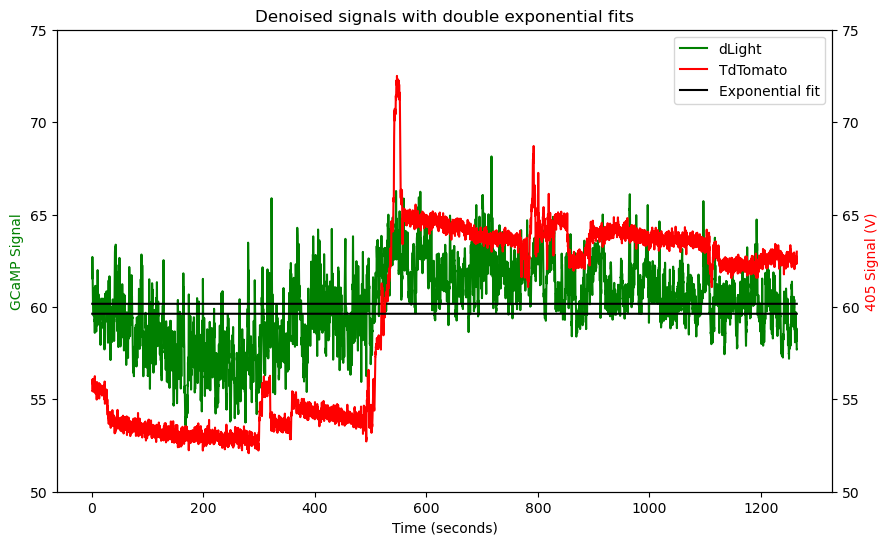

In [19]:
# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset. 
    amp_fast: Amplitude of the fast component.  
    amp_slow: Amplitude of the slow component.  
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow. 
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

# Fit curve to dLight signal.
max_sig = np.max(signal_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
signal_parms, parm_cov = curve_fit(double_exponential, time_seconds_1, signal_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
signal_expfit = double_exponential(time_seconds_1, *signal_parms)

# Fit curve to TdTomato signal.
max_sig = np.max(control_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
control_parms, parm_cov = curve_fit(double_exponential, time_seconds_1, control_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
control_expfit = double_exponential(time_seconds_1, *control_parms)

#plot fits over denoised data
fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_seconds_1, signal_denoised, 'g', label='GCaMP')
plot3=ax1.plot(time_seconds_1, signal_expfit, color='k', linewidth=1.5, label='Exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_denoised, color='r', label='405') 
plot4=ax2.plot(time_seconds_1, control_expfit,color='k', linewidth=1.5) 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal', color='g')
ax2.set_ylabel('405 Signal (V)', color='r')
ax1.set_title('Denoised signals with double exponential fits')

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
ax1.set_ylim(50, 75)
ax2.set_ylim(50, 75);

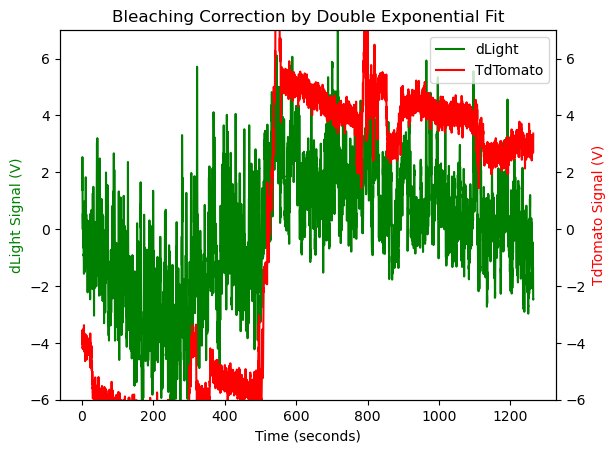

In [29]:
signal_detrended = signal_denoised - signal_expfit
control_detrended = control_denoised - control_expfit

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds_1, signal_detrended, 'g', label='GCaMP')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_detrended, color='r', label='405') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal', color='g')
ax2.set_ylabel('405 Signal', color='r')
ax1.set_title('Bleaching Correction by Double Exponential Fit')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
ax1.set_ylim(-6, 7)
ax2.set_ylim(-6, 7);

### Method 2: High Pass Filter
A simpler way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes. All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.

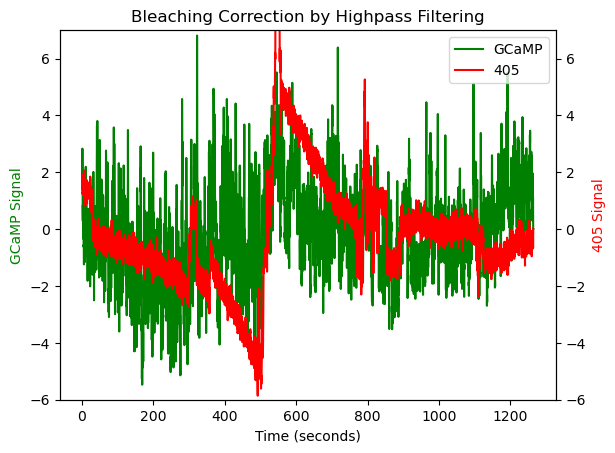

In [26]:
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
signal_highpass = filtfilt(b,a, signal_denoised, padtype='even')
control_highpass = filtfilt(b,a, control_denoised, padtype='even')


fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds_1, signal_highpass, 'g', label='GCaMP')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_highpass, color='r', label='405') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal', color='g')
ax2.set_ylabel('405 Signal', color='r')
ax1.set_title('Bleaching Correction by Highpass Filtering')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
ax1.set_ylim(-6, 7)
ax2.set_ylim(-6, 7);

## Motion correction
We now do motion correction by finding the best linear fit of the 405 signal to the GCaMP6f signal and subtracting this estimated motion component from the GaMP6f signal. We will use the data that was bleaching corrected using the double exponential fit as this is less likely to remove meaningful slow variation in the signals.

Slope    : 0.285
R-squared: 0.449


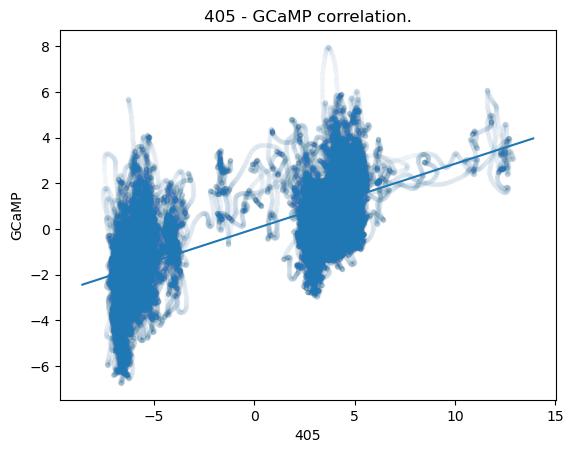

In [30]:
slope, intercept, r_value, p_value, std_err = linregress(x=control_detrended, y=signal_detrended)

plt.scatter(control_detrended[::5], signal_detrended[::5],alpha=0.01, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('405')
plt.ylabel('GCaMP')
plt.title('405 - GCaMP correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

We now calculate the estimated motion component of the GCaMP signal and subtract to get the motion corrected signal.

(1000.0, 1060.0)

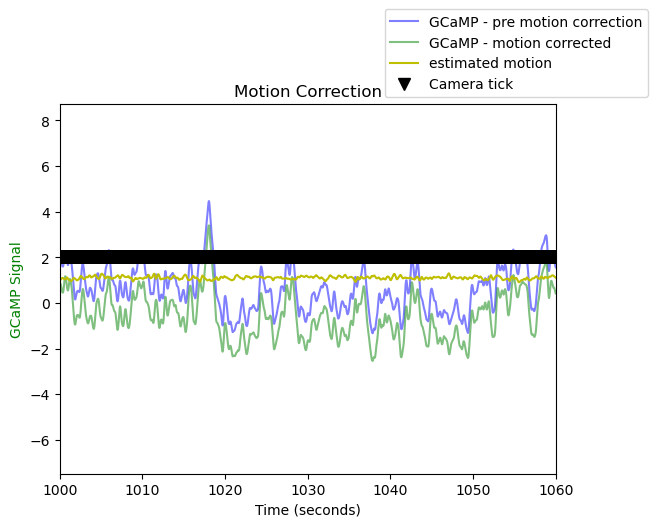

In [32]:
signal_est_motion = intercept + slope * control_detrended
signal_corrected = signal_detrended - signal_est_motion

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds_1, signal_detrended, 'b' , label='GCaMP - pre motion correction', alpha=0.5)
plot3=ax1.plot(time_seconds_1, signal_corrected, 'g', label='GCaMP - motion corrected', alpha=0.5)
plot4=ax1.plot(time_seconds_1, signal_est_motion - 0.05, 'y', label='estimated motion')
camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 2), label='Camera tick',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4+ camera_ticks
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1.2, 1))

ax1.set_xlim(1000, 1060)  # 60 sec window
# ax1.set_ylim(-0.075, 0.1);

## Normalization## Normalization

Typically in a photometry experiment we want to combine data across sessions and/or subjects. This is complicated by the fact that different sessions may have different levels of fluorphore expression, excitation light and autofluorescence. It is therefore desirable to normalise the data to reduce this variability. The two most widely used ways of doing this are computing dF/F or z-scores.

### Method 1: dF/F
To compute dF/F we divide the signal changes (dF) by the baseline fluorescence (F) and multiply by 100 to convert to percent. The dF is just the motion corrected signal plotted above. The baseline fluorescence F changes over the course of the session due to photobleaching, and is just the baseline we estimated with our double exponential fit.

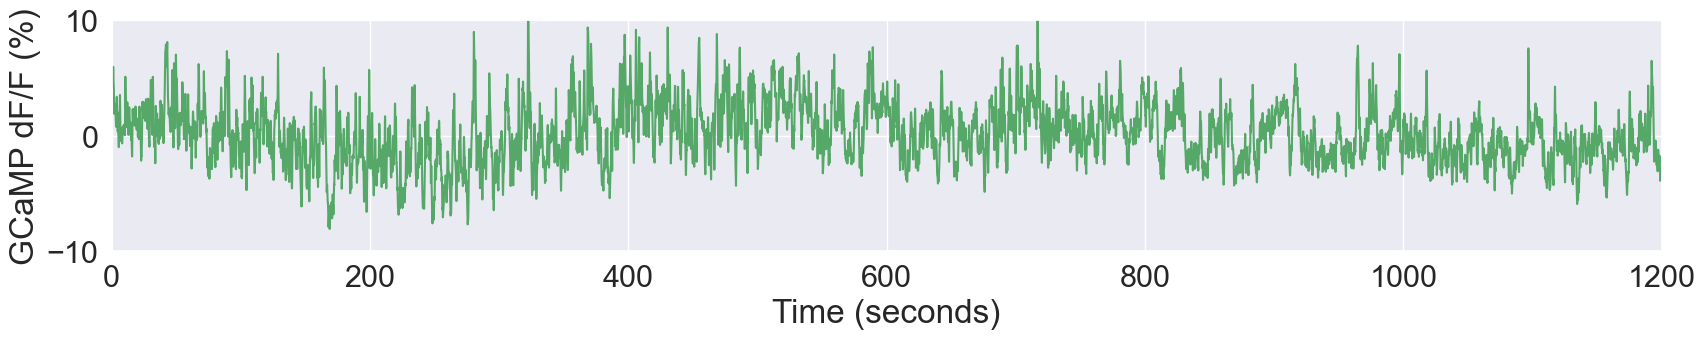

In [71]:
signal_dF_F = 100*signal_corrected/signal_expfit

fig,ax1=plt.subplots(figsize=(20,3))  
plot1=ax1.plot(time_seconds_1, signal_dF_F, 'g', label='GCaMP dF/F')
# camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 2), label='Camera tick',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP dF/F (%)')
# ax1.set_title('GCaMP dF/F')

lines = plot1
labels = [l.get_label() for l in lines]  
# legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

sns.set(font_scale=2)
ax1.set_xlim(0, 1200)
ax1.set_ylim(-10, 10);

### Method 2: Z-scoring

Alternatively, we can normalise the data by z-scoring each session - i.e. subtracting the mean and dividing by the standard deviation.

(10.0, 70.0)

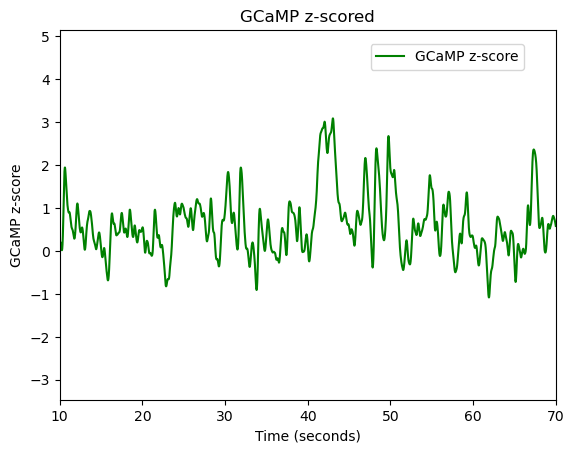

In [34]:
signal_zscored = (signal_corrected-np.mean(signal_corrected))/np.std(signal_corrected)


fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds_1, signal_zscored, 'g', label='GCaMP z-score')
# reward_ticks = ax1.plot(reward_cue_times, np.full(np.size(reward_cue_times), 6), label='Reward Cue',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP z-score')
ax1.set_title('GCaMP z-scored')

lines = plot1
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

ax1.set_xlim(10, 70)
# ax1.set_ylim(-3, 7);

In [75]:
df_position = pd.read_csv('./240403_164206_Cam1.csv', header=0, index_col=0)
df_position.head()

,x,y,roi,transition_index
0,294.317596,95.039749,Middle,NaN
1,365.677582,155.701645,Middle,NaN
2,369.147186,157.798264,Middle,NaN
3,371.262726,163.924698,Middle,NaN
4,374.062775,165.847626,Middle,NaN


In [36]:
# 낮은 샘플링 속도의 camera ticks
Camera_tick = pd.DataFrame({
    'onset': FPdata.epocs.Cam1.onset,
    'offset': FPdata.epocs.Cam1.offset, 
    'location': df_position.roi.iloc[0:len(FPdata.epocs.Cam1.onset)]  
})

# 높은 샘플링 속도의 GCaMP signal
GCaMP_signal = pd.DataFrame({
    'time': time_seconds_1,  
    'value': signal_dF_F  
})


# 판정 결과를 높은 샘플링 속도의 데이터셋에 추가
GCaMP_signal['location'] = ""  # 판정 결과를 저장할 열을 추가하고 초기값을 False로 설정


# 낮은 샘플링 속도의 데이터셋의 각 시간 범위에 대해 해당 범위 내의 높은 샘플링 속도의 데이터를 추출하여 판정 결과 업데이트
for index, row in Camera_tick.iterrows():
    start_time = row['onset']
    end_time = start_time + row['offset']  # 낮은 샘플링 속도의 데이터셋은 5분 간격으로 측정되므로 범위를 5분으로 설정
    
    # 해당 시간 범위 내의 높은 샘플링 속도의 데이터를 추출하여 판정 결과 업데이트
    GCaMP_signal.loc[(GCaMP_signal['time'] >= start_time) & 
                                (GCaMP_signal['time'] < end_time), 'location'] = row['location']

# 결과 출력
print("Camera_tick:")
print(Camera_tick)
print("\nGCaMP_signal:")
print(GCaMP_signal)

Camera_tick:
             onset       offset location
0         0.576225     0.618824   Middle
1         0.618824     0.664863   Middle
2         0.664863     0.716964   Middle
3         0.716964     0.764641   Middle
4         0.764641     0.814776   Middle
...            ...          ...      ...
25271  1264.131604  1264.174694      NaN
25272  1264.174694  1264.233021      S_1
25273  1264.233021  1264.274801      S_1
25274  1264.274801  1264.325591      S_1
25275  1264.325591          inf      S_1

[25276 rows x 3 columns]

GCaMP_signal:
                time     value location
0           1.000735  4.279165   Middle
1           1.001718  4.290941   Middle
2           1.002701  4.302758   Middle
3           1.003684  4.314614   Middle
4           1.004667  4.326509   Middle
...              ...       ...      ...
1285122  1264.327040 -5.698542      S_1
1285123  1264.328023 -5.698509      S_1
1285124  1264.329006 -5.698480      S_1
1285125  1264.329989 -5.698456      S_1
1285126  1264.

In [38]:
print("mean dF/F in Middle zone:")
print(GCaMP_signal[GCaMP_signal['location']=='Middle']['value'].mean())
print("\nmean dF/F in S1 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='S_1']['value'].mean())
print("\nmean dF/F in O1 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='O_1']['value'].mean())
print("\nmean dF/F in S2 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='S_2']['value'].mean())
print("\nmean dF/F in S3 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='S_3']['value'].mean())
print("\nmean dF/F in O2 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='O_2']['value'].mean())

mean dF/F in Middle zone:
0.05064048354955798

mean dF/F in S1 zone:
-0.6966600793359633

mean dF/F in O1 zone:
0.6986937736517452

mean dF/F in S2 zone:
1.0882805616000601

mean dF/F in S3 zone:
1.8775367508068257

mean dF/F in O2 zone:
1.5968111520146075


In [44]:
GCaMP_signal.value.describe()

count    1.285127e+06
mean    -1.627728e-15
std      2.625064e+00
min     -8.068111e+00
25%     -1.819825e+00
50%     -1.169974e-01
75%      1.683629e+00
max      1.248067e+01
Name: value, dtype: float64

In [39]:
import seaborn as sns

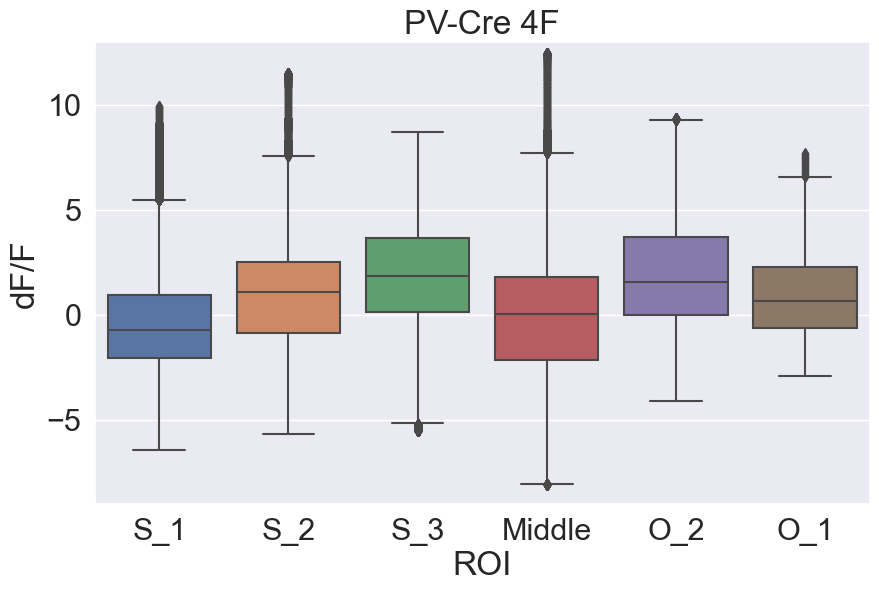

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))

boxplot=sns.boxplot(data=GCaMP_signal, 
                      x='location', 
                      y='value',
                      order=['S_1', 'S_2', 'S_3', 'Middle', 'O_2', 'O_1'])
boxplot.set(xlabel='ROI', ylabel='dF/F', ylim=(-9, 13), title='PV-Cre 4F')

sns.set(font_scale=2)

plt.show()

## Epoch averaging

C:\Users\YGKim_IBS\AppData\Local\Temp\ipykernel_20092\727567957.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] -= selected_event_time


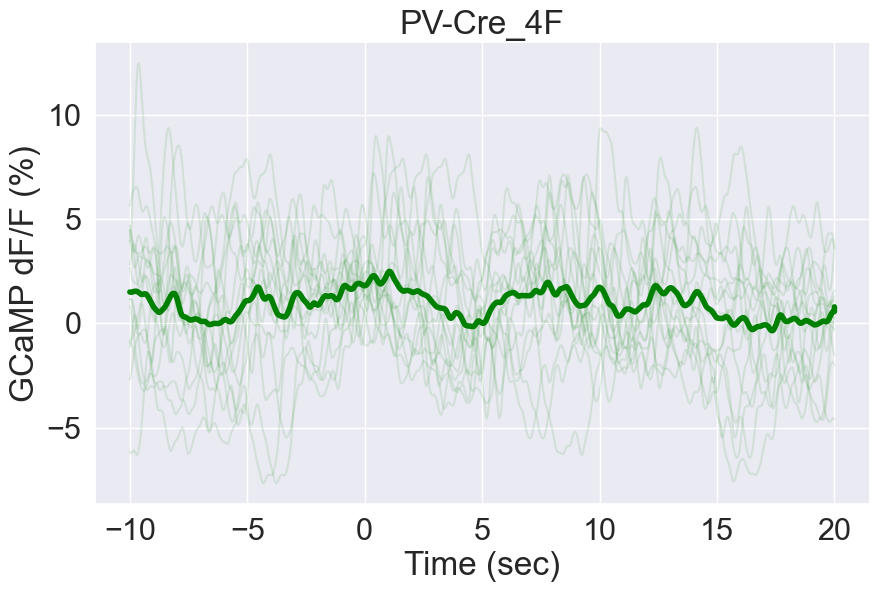

In [81]:
# 이벤트들과 그 시간을 포함한 데이터프레임 생성
events_data = {
    'event': df_position.transition_index[0:len(FPdata.epocs.Cam1.onset)],
    'event_time': FPdata.epocs.Cam1.onset
}
events_df = pd.DataFrame(events_data)

# 선택한 이벤트
selected_event = 2

# 선택한 이벤트에 해당하는 행 필터링
selected_events_data = events_df[events_df['event'] == selected_event]

# 그래프 생성
plt.figure(figsize=(10, 6))


# 각 이벤트에 대해 데이터를 추출하고 lineplot으로 그림
all_lines = []  

# 모든 line들을 저장하기 위한 리스트
for index, row in selected_events_data.iterrows():
    selected_event_time = row['event_time']

    # 이벤트 발생 시간을 기준으로 10초 전부터 20초 후까지의 데이터 추출
    start_time = selected_event_time - 10
    end_time = selected_event_time + 20
    filtered_data = GCaMP_signal[(GCaMP_signal['time'] >= start_time) & (GCaMP_signal['time'] <= end_time)]

    # 시간을 조정하여 데이터 시점을 맞춤
    filtered_data['time'] -= selected_event_time

    # lineplot 그리기 (투명도를 조절하여 녹색으로 표시)
    x_data = filtered_data['time']
    y_data = filtered_data['value']
    
    line, = plt.plot(x_data, y_data, color='green', alpha=0.1)
    all_lines.append(y_data.values)  # 각 시점에서의 데이터들을 저장

# 모든 시점에서의 데이터들을 2차원 배열로 변환
all_lines = pd.DataFrame(all_lines)

# 각 시점에서의 데이터들의 평균값 계산
mean_values = all_lines.mean(axis=0)

# x_data는 시간 데이터로 공통이므로, 처음 시점에서만 가져옴
x_data = filtered_data['time']

# 각 시점에서의 데이터들의 평균값을 녹색선으로 표시
min_length = min(len(x_data), len(mean_values))
x_data = x_data[:min_length]
mean_values = mean_values[:min_length]

plt.plot(x_data, mean_values, color='green', label='Mean Value', linewidth=4)

# 각 이벤트에 대해 lineplot으로 그림 (투명도를 조절하여 녹색으로 표시)
# for index, row in selected_events_data.iterrows():
#     selected_event_time = row['event_time']
#     start_time = selected_event_time - 10
#     end_time = selected_event_time + 20
#     plt.plot(filtered_data['time'], filtered_data['value'], color='green', alpha=0.1)

# 그래프 제목과 레이블 추가
plt.title('PV-Cre_4F')
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')

# 범례 추가
# plt.legend()

# 그래프 출력
plt.grid(True)
plt.show()